# Results
Here, we will inspect the already trained model and its capabilities. However, we will not be evaluating performance here.

### List of Contents
- [Set Global Params](#set-global-params)
- [Inspect Model](#inspect-model)
    - Model Summary
    - Test input/output
    - Sample Images
    - Denoise Images
    - Inspect Filters
- [Generate Rotational Images](#generate-rotational-images)
- [Misc. functionalities](#misc-functionalities)
    - Save MNIST dataset from CSV to PNG images
    - Make Collage of Training Images


First, let's import the libraries.

In [1]:
import torch
from modules.utils import *
from modules.filtrs import *
from modules.utils import *
from modules.ddpm_utils import *
from modules.ddpm_models import *
from modules.ddpm_tasks import rotation_results,make_video
import pickle

## Set Global Params

In [2]:
# global 
random_seed=42
args = argument()
args.image_size = 32
args.image_channels=1
args.device = "cuda"
args.noise_steps=1000

## Inspect Model

In [9]:
args=args
unet_variant=3
f_settings={}
f_settings['kernel_size']=3
f_settings['kaiser_beta']=2
f_settings['omega_c_down'] =np.pi/2
f_settings['omega_c_up'] = np.pi/2

modelpath="E:\Research\Diffusion-Models-pytorch\models\DDPM_Uncondtional_MNIST_3\ckpt_MNIST_3.pt"

set_seed(random_seed)
model = UNet(c_in=args.image_channels, c_out=args.image_channels,
            image_size=args.image_size,f_settings=f_settings,device=args.device,variant=unet_variant).to(args.device)
ckpt = torch.load(modelpath)
model.load_state_dict(ckpt)
diffusion = Diffusion(noise_steps=args.noise_steps,img_size=args.image_size, device=args.device)


Variant 3 Modified UNet: filters around gelu + filters in up or downsampling
Unconditional UNet


### Model summary

In [ ]:
print(sum([p.numel() for p in model.parameters()]))
print(model)

### Test input/output of the Model

In [7]:
x = torch.randn(2, args.image_channels, args.image_size, args.image_size).to(args.device)
t = x.new_tensor([args.noise_steps] * x.shape[0]).long().to(args.device)
y = x.new_tensor([1] * x.shape[0]).long().to(args.device)
#print(net(x, t, y).shape) # conditional case
print(model(x, t).shape)

torch.Size([2, 1, 32, 32])


### Sample Images

999it [00:32, 30.43it/s]


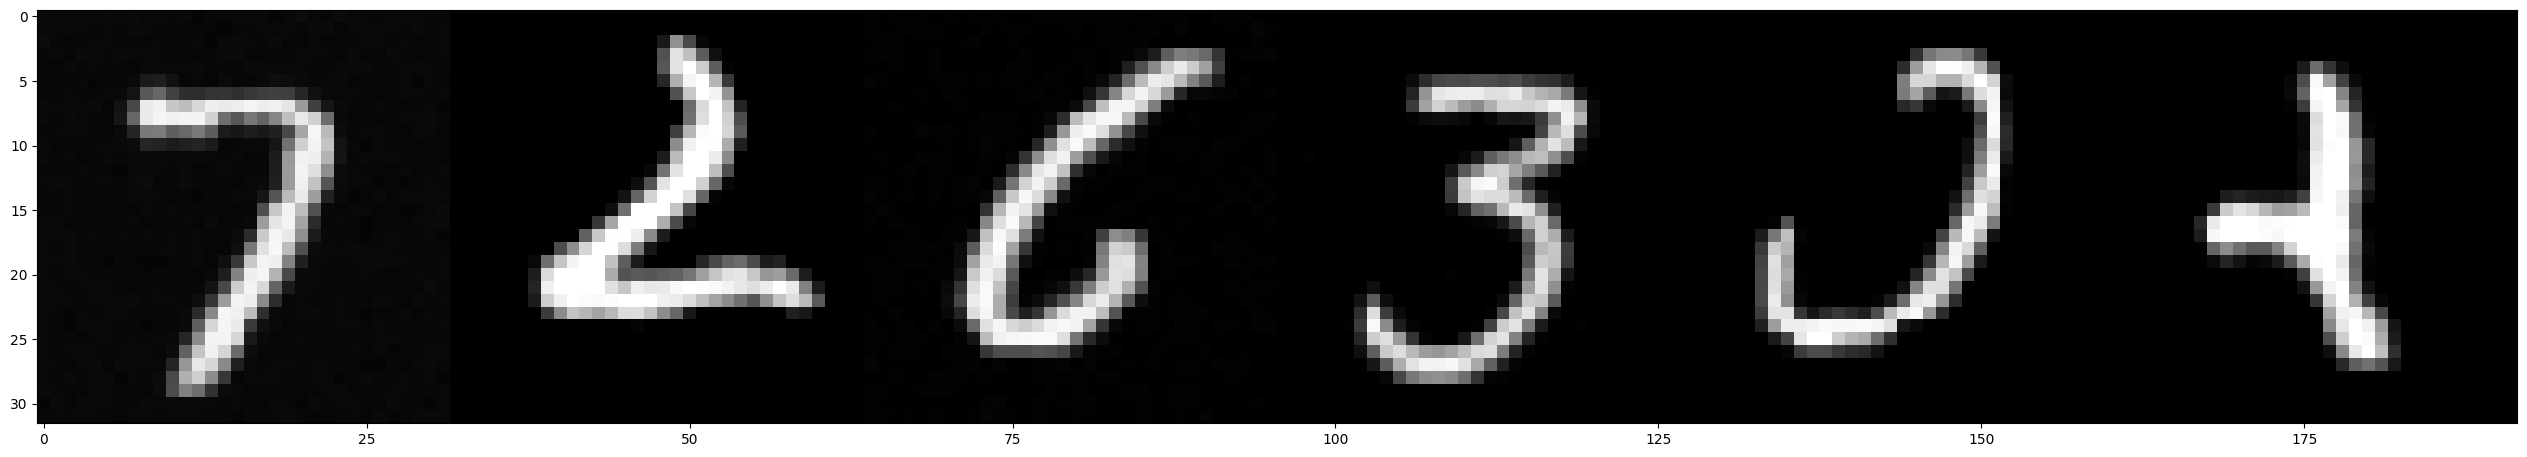

In [10]:
x = diffusion.sample(model, n=6,image_channels=args.image_channels)
plot_images(x)

### Denoise Images

999it [00:32, 30.95it/s]


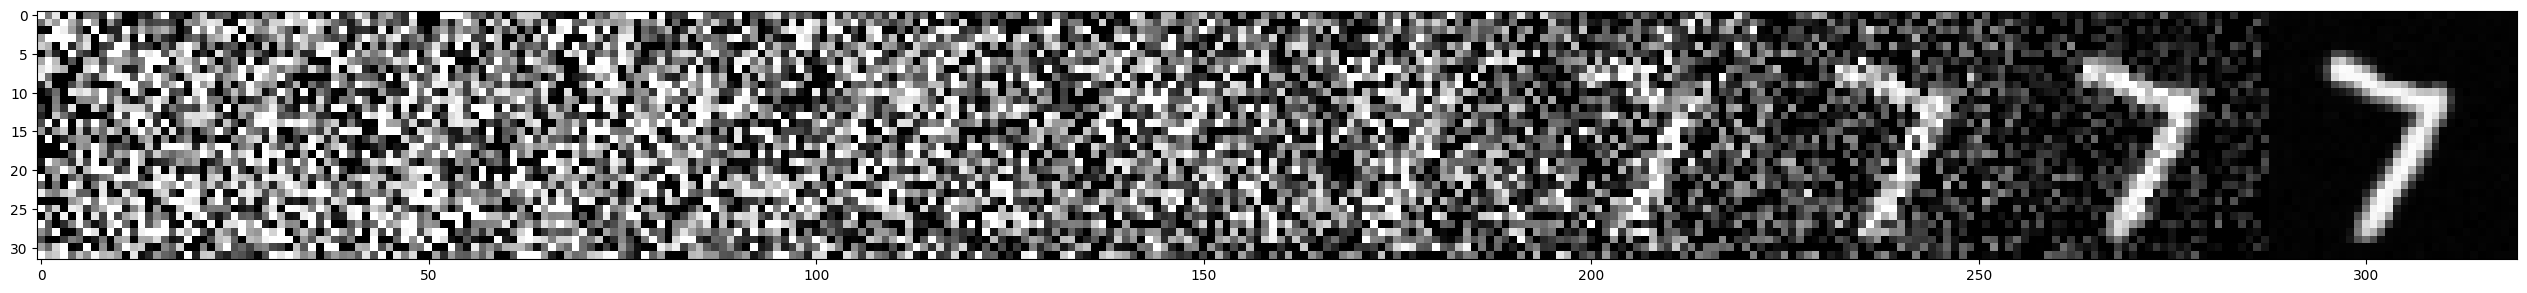

torch.Size([10, 1, 32, 32])

In [11]:
set_seed(random_seed)
denoise_img = diffusion.revert(model, n=1,image_channels=args.image_channels)
plot_images(denoise_img)
denoise_img.shape

### Inspect Filters

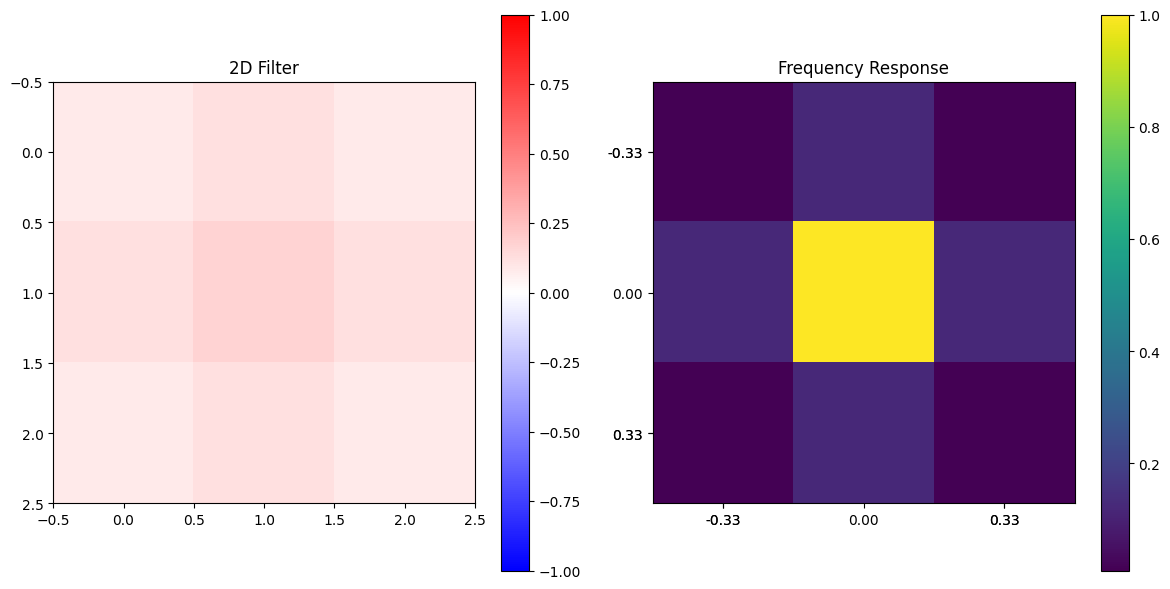

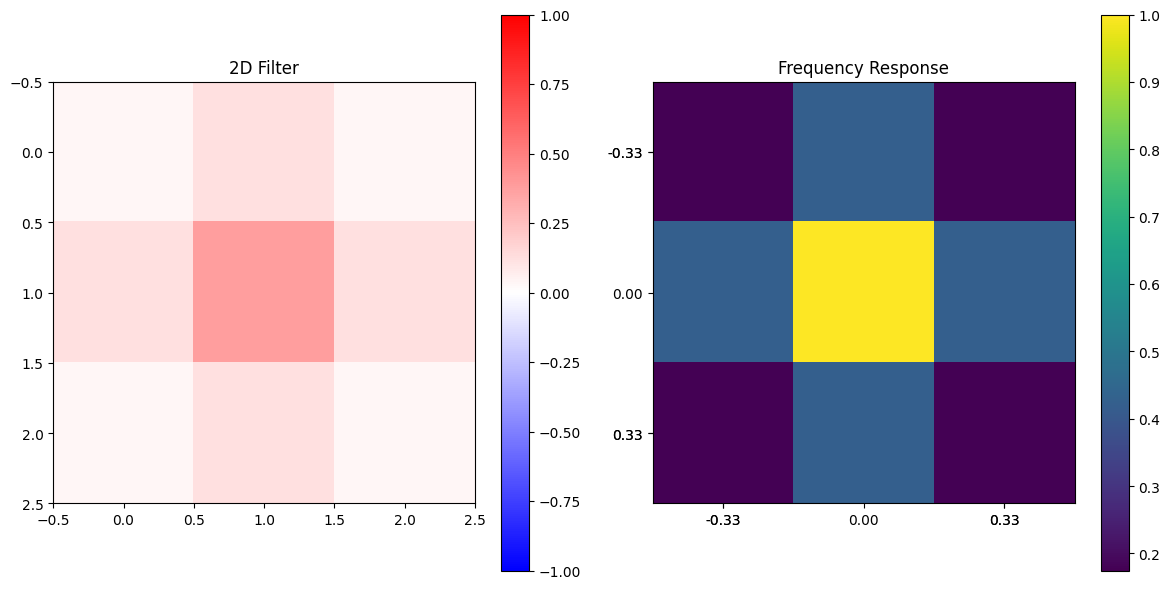

In [12]:
if f_settings is not None:
    filter_size=f_settings['kernel_size']
    beta=f_settings['kaiser_beta']

    filters=[]
    filters.append(circularLowpassKernel(f_settings['omega_c_down'], filter_size))
    filters.append(circularLowpassKernel(f_settings['omega_c_up'], filter_size,beta=beta))

    for filter in filters:  
        plot_filter_and_response(filter)


## Generate Rotational Images

In [3]:
thatas=np.linspace(-45,180,60)
# model paths
modelpath_ref="E:\models_MNIST\DDPM_Uncondtional_MNIST_0\ckpt_MNIST_0.pt"
modelpath_test="E:\models_MNIST\DDPM_Uncondtional_MNIST_3\ckpt_MNIST_3.pt"
#name of the file to save results
fname='MNIST_rotational_results.pkl'

# for making videos
fps=15
ref_filename='video_MNIST_b16b0_0'
test_filename='video_MNIST_b16b0_3'

[-45.   0.  45.]
[-8 -4  0  4  8]


In [4]:
# reference model
f_settings_ref=None
model_data_ref={
    'unet_v': 0,
    'args': args,
    'f_settings': f_settings_ref,
    'seed': random_seed,
   'modelpath': modelpath_ref
}

# test model
f_settings={}
f_settings['kernel_size']=3
f_settings['kaiser_beta']=0
f_settings['omega_c_down'] =np.pi/2
f_settings['omega_c_up'] = np.pi/2
model_data_test={
    'unet_v': 3,
    'args': args,
    'f_settings': f_settings,
    'seed': random_seed,
   'modelpath': modelpath_test
}

In [5]:
x_ref=rotation_results(model_data_ref,thatas)
x_test=rotation_results(model_data_test,thatas)

Variant 0 Original UNet
Unconditional UNet


999it [00:20, 49.56it/s]:00<?, ?it/s]
999it [00:19, 51.66it/s]:20<00:40, 20.17s/it]
999it [00:19, 51.31it/s]:39<00:19, 19.68s/it]
100%|██████████| 3/3 [00:58<00:00, 19.66s/it]


Variant 3 Modified UNet: filters around gelu + filters in up or downsampling
Unconditional UNet


999it [00:31, 31.79it/s]:00<?, ?it/s]
999it [00:31, 31.86it/s]:31<01:02, 31.43s/it]
999it [00:31, 31.48it/s]:02<00:31, 31.39s/it]
100%|██████████| 3/3 [01:34<00:00, 31.51s/it]


In [6]:
fdata={
    'x_ref': x_ref,
    'x_test': x_test,
    'modeldata_ref': model_data_ref,
    'modeldata_test': model_data_test,
    'thetas': thatas
}

with open(fname,'wb') as file:
    pickle.dump(fdata,file)

In [ ]:
# select an index from 0 to 3 
im_i=2
print(thatas)
images_ref = torch.stack([tensor[im_i] for tensor in x_ref])
images_test = torch.stack([tensor[im_i] for tensor in x_test])

[-45.   0.  45.]


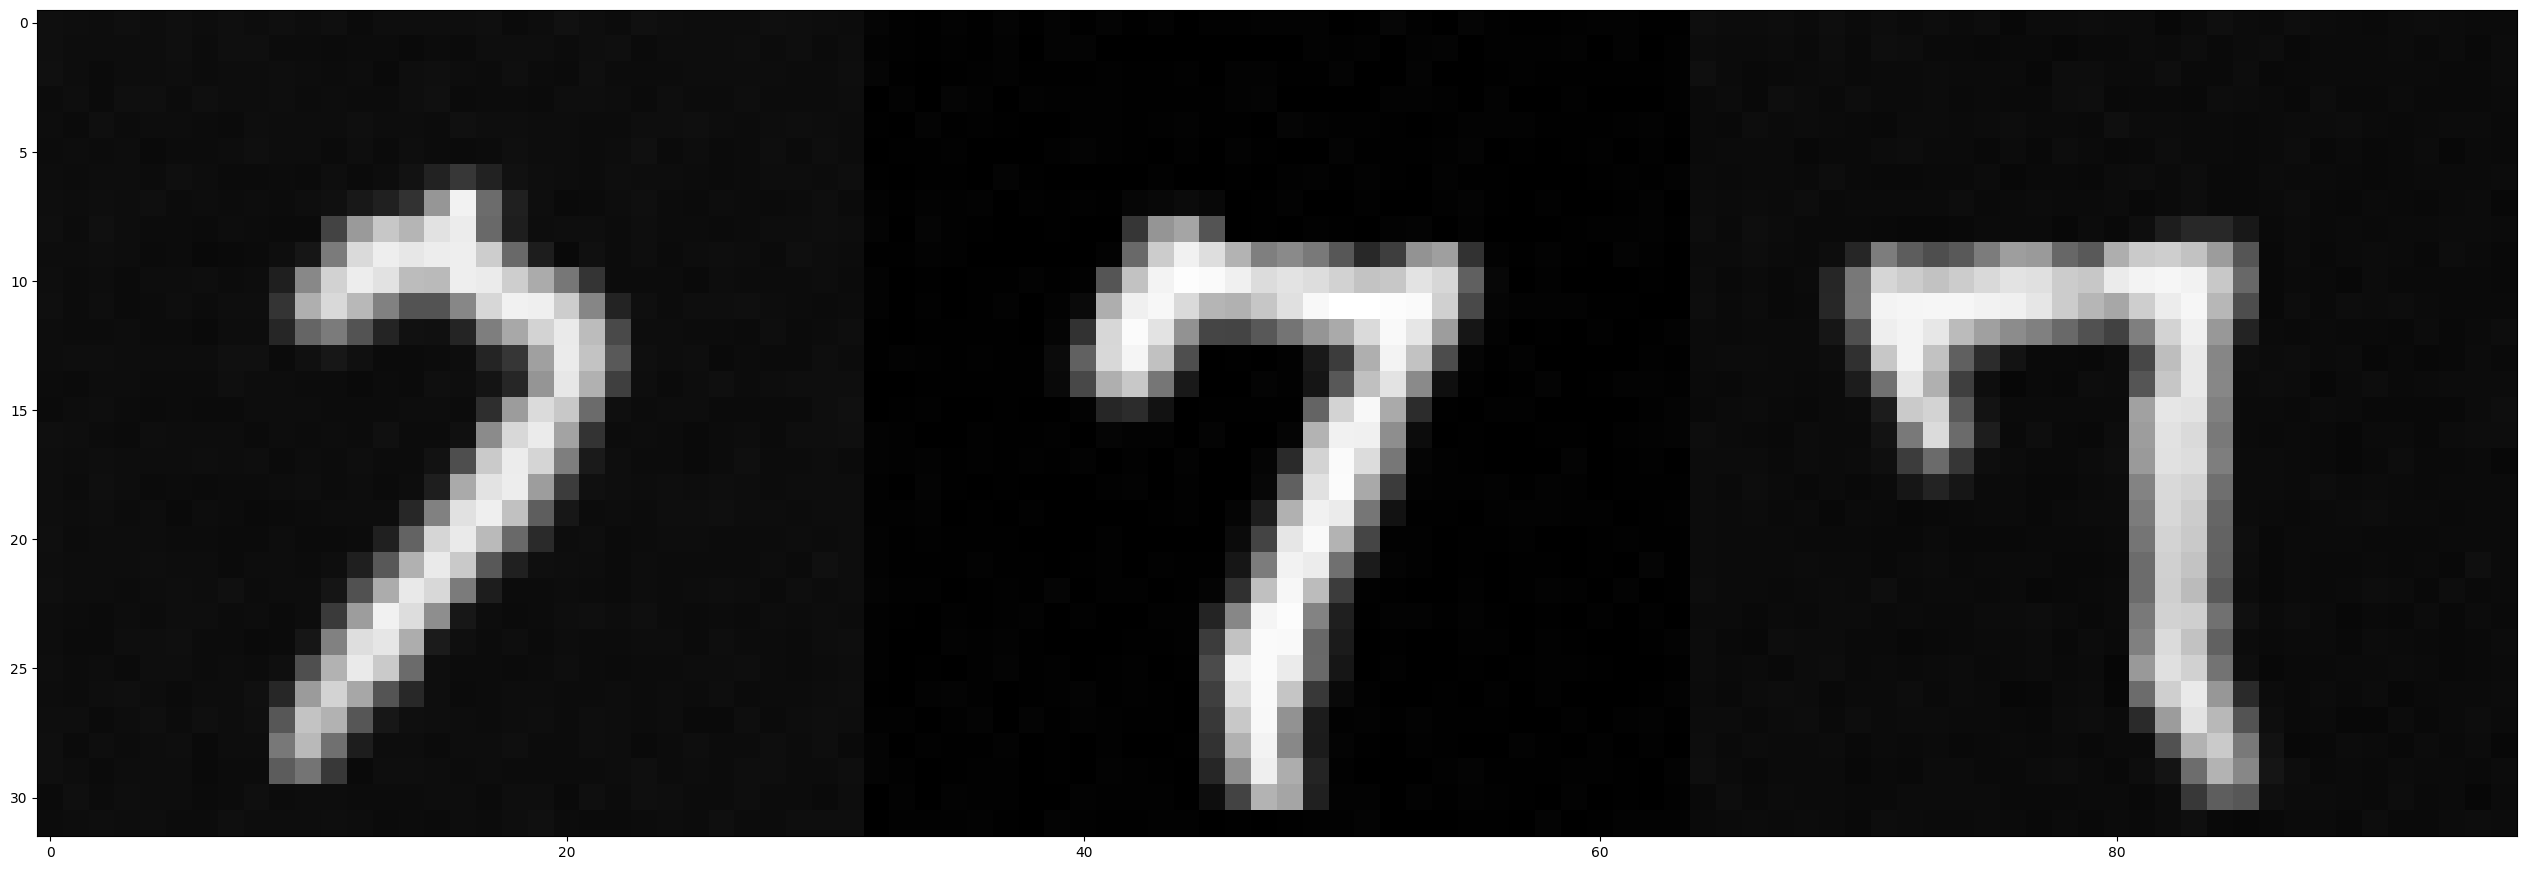

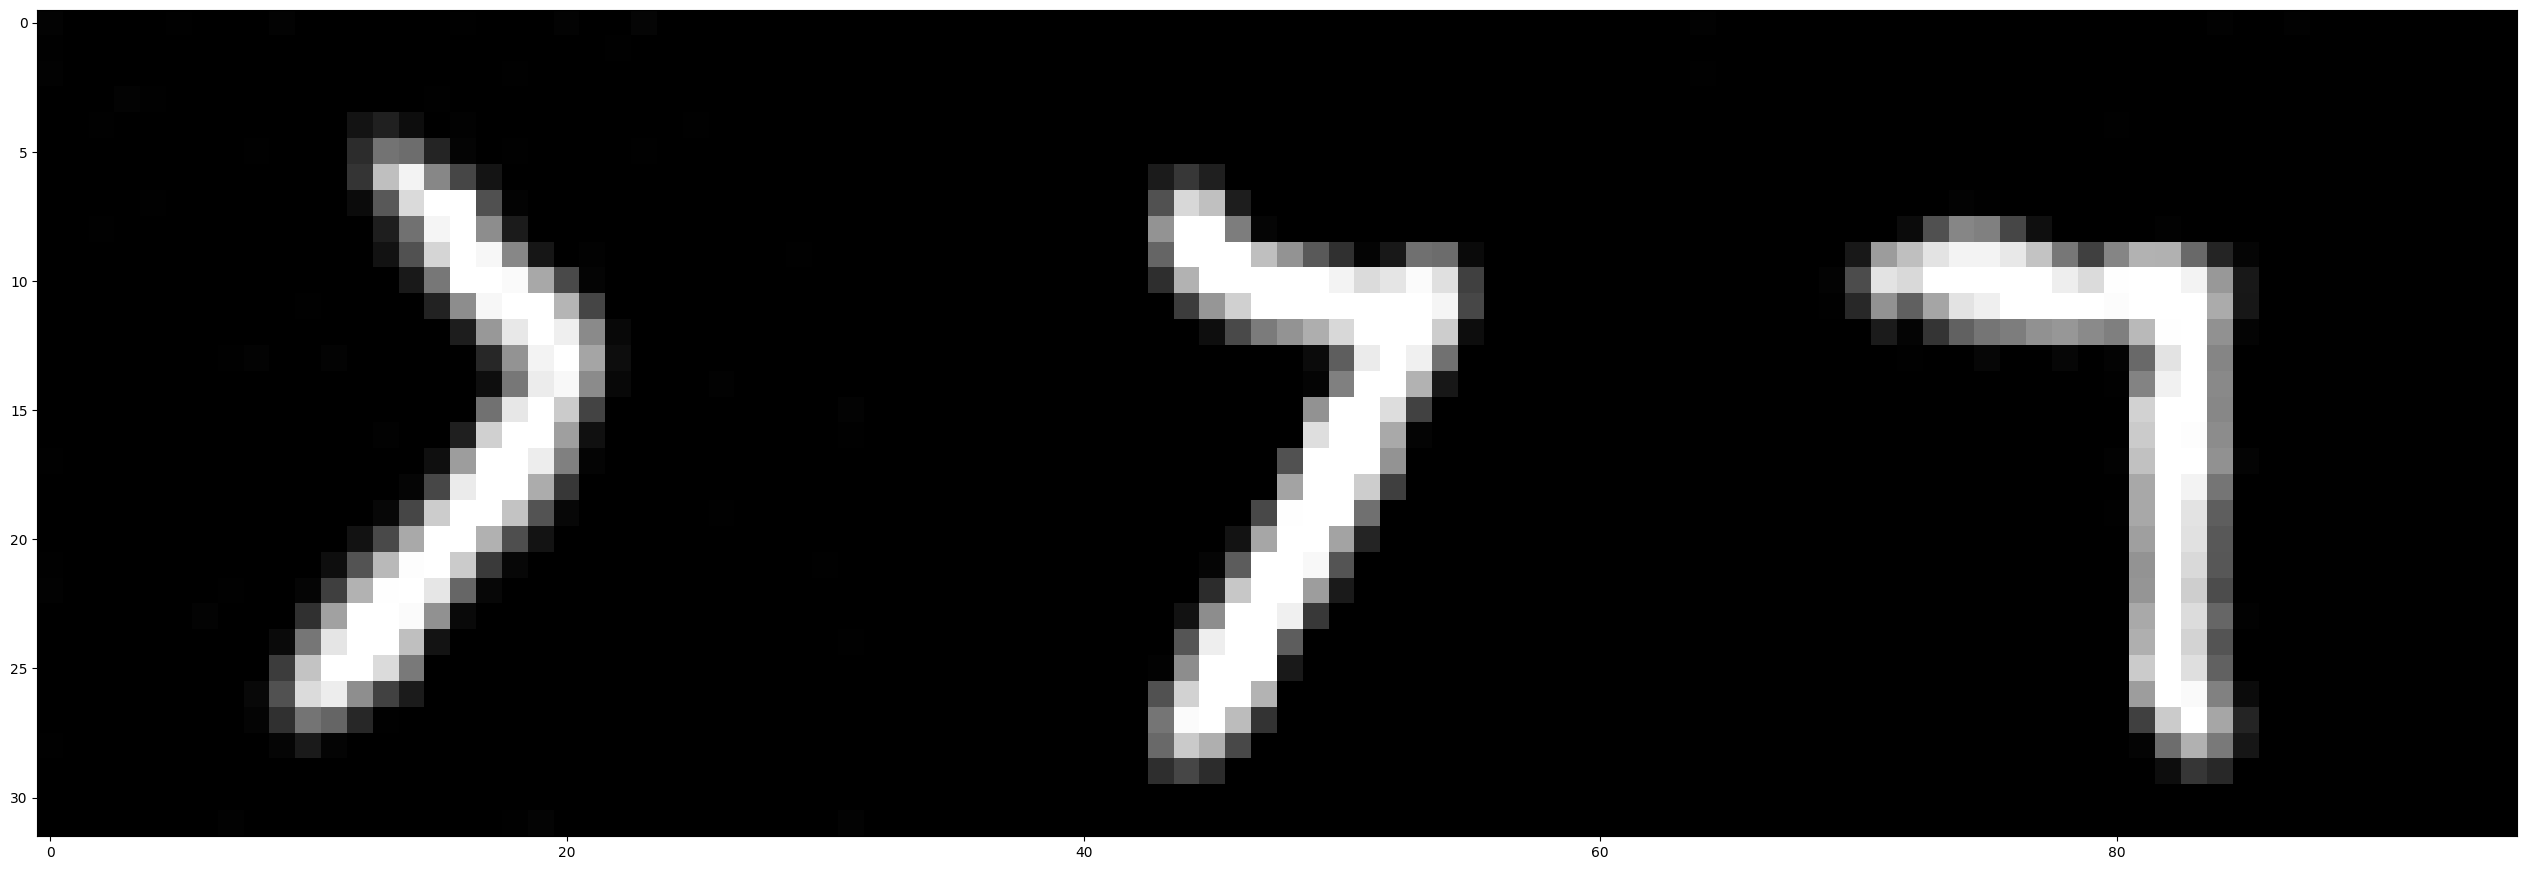

"\nfps=15\nref_filename='video_MNIST_b16b0_0'\ntest_filename='video_MNIST_b16b0_3'\nmake_video(images_ref,ref_filename,fps=fps)\nmake_video(images_test,test_filename,fps=fps)\n"

In [7]:
plot_images(images_ref)
plot_images(images_test)

In [ ]:
make_video(images_ref,ref_filename,fps=fps)
make_video(images_test,test_filename,fps=fps)

In [8]:
save_gif(ref_filename,fps,'128')
save_gif(test_filename,fps,'128')

## Misc. functionalities

### Save MNIST dataset from CSV to PNG images

In [ ]:
import os
from modules import utils

current_directory = os.getcwd() 
csv_path = os.path.join(current_directory,"data/MNIST/mnist_train_small.csv")
save_path= os.path.join(current_directory,"trdata/MNIST")

utils.save_dataset_MNIST_CSV2PNG(csv_path,save_path)

### Make Collage of Training Images

In [ ]:
from modules.utils import make_collage

gen_savepath="E:\MNIST-M-6000"

image_size=32
images_per_collage=400
total_image_collage=2000
make_collage(gen_savepath,gen_savepath,images_per_collage,total_image_collage,image_size)